In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sqlalchemy import create_engine
import warnings

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query(f'select * from {postgres_db}',con=engine)

# No need for an open connection,
# because you're only doing a single query
engine.dispose()

In [8]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [10]:
# Make sure the number of rows divides evenly into four samples.
rows = df.shape[0] - df.shape[0] % 2
df = df.iloc[:rows, :]

# Break into a set of features and a variable for the known outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace some random string values.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

# Normalize
X_std = StandardScaler().fit_transform(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=123)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):

    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]

    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

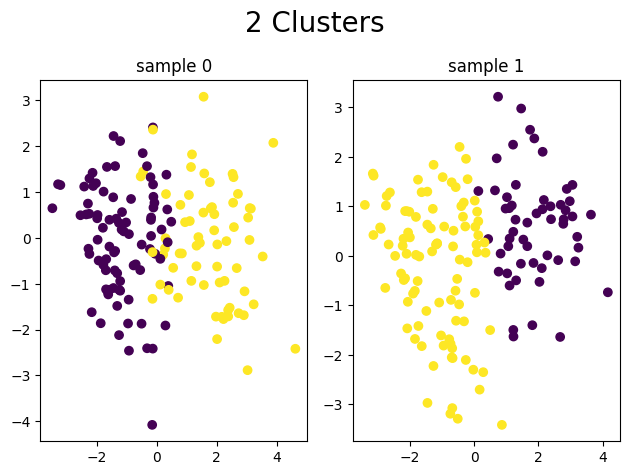

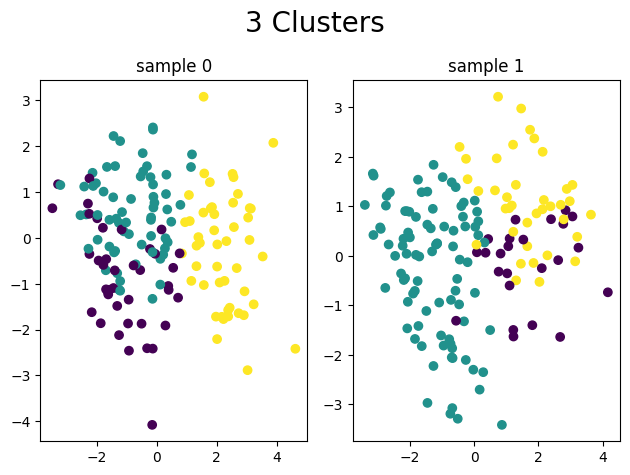

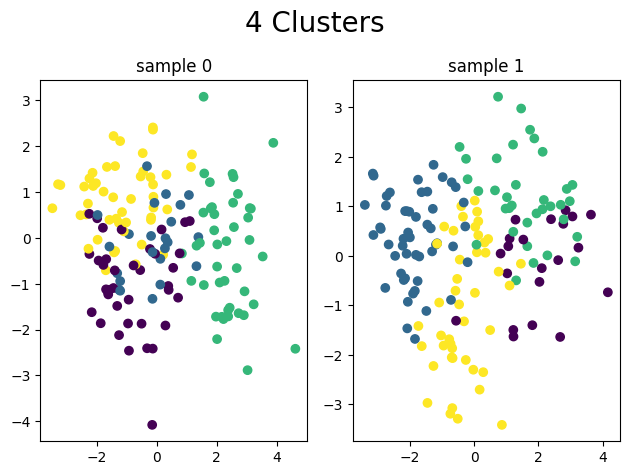

In [11]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):

    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)

    # Make a plot for each sample.
    for i in range(2):

        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]

        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]

        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
        axarr[i].set_xlim()
        axarr[i].set_ylim()

    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

In [12]:
pred_2 = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
pred_3 = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
pred_4 = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)

print("ARI for two cluster k-means: {}".format(
    metrics.adjusted_rand_score(y, pred_2)))
print("ARI for three cluster k-means: {}".format(
    metrics.adjusted_rand_score(y, pred_3)))
print("ARI for four cluster k-means: {}".format(
    metrics.adjusted_rand_score(y, pred_4)))

ARI for two cluster k-means: 0.40215267117910686
ARI for three cluster k-means: 0.30050779570637265
ARI for four cluster k-means: 0.2228703205564274


In [13]:
pred_2 = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
pred_3 = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
pred_4 = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)

print("Silhouette score for two cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_2, metric='euclidean')))
print("Silhouette score for three cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_3, metric='euclidean')))
print("Silhouette score for four cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_4, metric='euclidean')))

Silhouette score for two cluster k-means: 0.1713676650409436
Silhouette score for three cluster k-means: 0.12558008720112157
Silhouette score for four cluster k-means: 0.1119064981244127


# Best ARI/Silhouette scores: 2-Cluster K-Means